### Imports and Configuration

In [1]:
import gymnasium as gym

import time
import numpy as np
import matplotlib.pyplot as plt
import itertools
from tqdm.notebook import tqdm
import pandas as pd
from collections import deque
import os
from IPython.display import clear_output
import pickle

In [2]:
default_config = {
    "lanes_count" : 10,
    "vehicles_count": 50,
    "duration": 120,
    "other_vehicles_type": "highway_env.vehicle.behavior.IDMVehicle",
    "initial_spacing": 2, 
    "action": {"type": "DiscreteMetaAction",},
    "simulation_frequency": 15,
    "policy_frequency": 5,
    "collision_reward": -1, 
    "right_lane_reward": 0.1,
    "high_speed_reward": 100, 
    "lane_change_reward": 0,
    "reward_speed_range": [20, 30],
    "screen_width": 800,  
    "screen_height": 600,
    "centering_position": [0.5, 0.5],
    "scaling": 5,
    "show_trajectories": True,
    "render_agent": True,
    "offscreen_rendering": False
}

### Checking the environment 

In [3]:
occupancyGrid = configuration.copy()
occupancyGrid["observation"] =  {
    "type": "OccupancyGrid",
    # "vehicles_count": 50,
    "features": [
                "presence",
                #"x", "y", 
                #"vx", "vy"
                ],
    # "features_range": {
    #      "x": [-500, 500],
    #      "y": [-500, 500],
    #     "vx": [-20, 20],
    #     "vy": [-20, 20]
    # },
    "grid_size": [[-100, 100], [-100, 100]],    # X controls how many lanes, Y controls how far ahead
    "grid_step": [1, 1],
    #"absolute": False,                     # Not implemented in the library
    #"as_image": True,
    # "align_to_vehicle_axes" : True
}

# The higher the number, the more frequent the policy and the simulation frequencies, the slower the simulation
occupancyGrid["simulation_frequency"] = 15
occupancyGrid["policy_frequency"] = 1
occupancyGrid["normalize_reward"] = False

env = gym.make('highway-v0', render_mode='human', config=occupancyGrid)

obs, info = env.reset(seed = 30)
# Do one step
action = 3
obs, reward, done, truncated, info = env.step(action)
print("Reward:", reward)

env.close()

obs

NameError: name 'configuration' is not defined

- grid_size=[[-50, 50], [-50, 50]],  # X controls the lane-width, Y controls how far ahead
- grid_step=[1, 1],
- n_closest=3,
- ss_bins=[5,6],
- crop_dist=[[-10,10], [-10,25]],
- policy=None,
- sim_frequency=15,
- policy_frequency=5,
- render_mode = 'human',
- seed = 50,

!!! TODO !!!

- Use kinematics to substitute the current occupancy grid class

- He cannot know when he cant turn left or right because the lane is the final one

- Change the occupancy class to use occupancy grid with 5m grid size, 3 lanes and -30, 30 ahead

- Make a plot history 

- Check how many times each state is visited

- Check the action distribution, so as to see if slowing down is the most chosen action and the one with the best Q value

- Change the reward for colision, so that the agent goes faster

!!! IDEA WITH KINEMATICS !!!
- State space in this maner: (danger ahead, danger left, danger right, danger behind, lane position, (maybe) speed)
- Lane position can be 0 if in the middle, 1 if in the right, -1 if in the left

- We need speed, because if the speed is too fast, it might not be able to turn in time
- Actually, we could just increase the safety distance, and then we wouldn't need speed

___________________________
### Using kinematics

In [4]:
kinematics = configuration.copy()
kinematics["observation"] =  {
    "type": "Kinematics",
    "vehicles_count": 50,
    "features": ["x", "y", "vx", "vy"],
    # "features_range": {
    #     "x": [-40, 40],
    #     "y": [-40, 40],
    #     "vx": [-200, 200],
    #     "vy": [-200, 200]
    # }, 
    "absolute": False,
    "normalize": False,
}

# The higher the number, the more frequent the policy and the simulation frequencies, the slower the simulation
kinematics["simulation_frequency"] = 20
kinematics["policy_frequency"] = 5

env = gym.make('highway-v0', render_mode='human', config=kinematics)

obs, info = env.reset(seed = 10)

env.close()

obs

array([[ 83.56591  ,  28.       ,  25.       ,   0.       ],
       [  9.4535885,   8.       ,  -1.5146654,   0.       ],
       [ 20.187185 , -24.       ,  -1.9328905,   0.       ],
       [ 31.133034 , -24.       ,  -1.129222 ,   0.       ],
       [ 41.896053 ,   0.       ,  -1.7400944,   0.       ],
       [ 51.945835 ,  -8.       ,  -3.565016 ,   0.       ],
       [ 62.276524 , -16.       ,  -3.3216567,   0.       ],
       [ 72.60146  ,   8.       ,  -1.0905089,   0.       ],
       [ 82.24522  ,  -8.       ,  -2.182405 ,   0.       ],
       [ 91.352806 , -20.       ,  -3.5367248,   0.       ],
       [100.35392  , -16.       ,  -3.2140508,   0.       ],
       [109.795944 ,  -4.       ,  -3.2532372,   0.       ],
       [119.59274  ,   0.       ,  -1.6719042,   0.       ],
       [129.31784  ,   4.       ,  -2.6289418,   0.       ],
       [138.54662  ,  -4.       ,  -2.0985248,   0.       ],
       [149.64609  , -16.       ,  -1.698277 ,   0.       ],
       [159.69713  ,   0

In [4]:
# TODO make the dictionary less strict

optimum_q_kinematics = {
    (0,0,0,0,0,0) : 2, 
    (0,0,0,0,1,0) : 3,
    (0,0,0,0,-1,0) : 2, 
    (1,0,0,0,0,0) : 2,
    (1,0,0,0,1,0) : 0,
    (1,0,0,0,-1,0) : 2,
    (0,0,1,0,0,0) : 2,
    (0,0,1,0,1,0) : 3,
    (0,0,0,1,0,0) : 3,
    (0,0,0,1,-1,0) : 3,
    (1,0,1,1,0,0) : 4,
    (0,0,1,1,0,0) : 3,
    (1,0,0,1,0,0) : 0,
    (1,0,0,1,-1,0) : 4,
    (1,0,1,0,0,0) : 2,
    (1,0,1,0,1,0) : 4,
    (0,0,0,0,0,1) : 3,    # !! ALL 3s could have to be substituted with 4s 
    (0,0,0,0,1,1) : 3, 
    (0,0,0,0,-1,1) : 3,  # Could have only turned right before, so faster 
    (1,0,0,0,0,1) : 3,   # Car in front and just turned, so the car will soon be on my left or right
    (1,0,0,0,1,1) : 3,  
    (1,0,0,0,-1,1) : 3,
    (0,0,1,0,0,1) : 3,
    (0,0,1,0,1,1) : 3,
    (0,0,0,1,0,1) : 3,
    (0,0,0,1,-1,1) : 4,   # Car on the right, couldnt have turned left, so soon will be in front
    (1,0,1,1,0,1) : 4,    # Terrible, brace
    (0,0,1,1,0,1) : 4,    # Terrible 
    (1,0,0,1,0,1) : 3,    # I have turned left
    (1,0,0,1,-1,1) : 4,   # On the right and in front, have turned right, terrible
    (1,0,1,0,0,1) : 3,    # On the left and in front, have turned right
    (1,0,1,0,1,1) : 4,    # On the left, cant turn right, could only have turned left, terrible
    #(0,1,0,0,0) : 2,
    #(0,1,0,0,1) : 3,
    #(0,1,0,0,-1) : 2,
    # (0,0,1,0,-1) : 2,
    # (0,0,0,1,1) : 3,
    #(1,1,0,0,0) : 2,
    #(1,1,0,0,1) : 0,
    #(1,1,0,0,-1) : 2,
    #(1,1,1,0,0) : 2,
    #(1,1,1,0,1) : 2,
    # (1,1,1,0,-1) : 1,
    #(1,1,1,1,0) : 1,
    # (1,1,1,1,1) : 1,
    # (1,1,1,1,-1) : 1,
    #(1,1,0,1,0) : 0,
    # (1,1,0,1,1) : 0,
    #(1,1,0,1,-1) : 1,
    # (1,0,1,1,1) : 1,
    # (1,0,1,1,-1) : 1,
    # (0,1,1,1,0) : 3,
    # (0,1,1,1,1) : 3,
    # (0,1,1,1,-1) : 3,
    # (0,0,1,1,1) : 3,
    # (0,0,1,1,-1) : 3,
    # (0,1,0,1,0) : 3,
    # (0,1,0,1,1) : 3,
    # (0,1,0,1,-1) : 3,
    # (0,1,1,0,0) : 2,
    # (0,1,1,0,1) : 3,
    # (0,1,1,0,-1) : 2,
    # (1,0,0,1,1) : 0,
    #(1,0,1,0,-1) : 2,
}

In [5]:
def fix_reward(reward, position, action, to_right_reward=5, to_right_skewness=2, change_lane_reward=-0.5):
    """
    This function is used to correct the reward function, which is not correctly outputted by the environment
    Params: 
        reward: float, the reward to fix    
        position: tuple, the position of the car
        action: int, the action taken by the car
        to_right_reward: float, the reward to give to the driver 
        to_right_skewness: float, the skewness to apply to the to_right_reward
        change_lane_reward: float, the reward to give when changing lanes
    """
    
    lane = position[1]
    lane_value = to_right_reward * ((lane/36)**to_right_skewness)
    lane_change = 1 if action in [0, 2] else 0
    reward = reward + lane_value + lane_change * change_lane_reward    
    return reward

def decode_meta_action(action):
    """
    Function to output the corresponding action in text-form
    """
    assert action in range(5), "The action must be between 0 and 4"
    if action == 0:
        return "LANE_LEFT"
    elif action == 1:
        return "IDLE"
    elif action == 2:
        return "LANE_RIGHT"
    elif action == 3:
        return "FASTER"
    elif action == 4:
        return "SLOWER"
    
def decode_danger(state):
    """
    Function to decode the danger state
    """
    state_meaning = ['front', 'back', 'left', 'right']
    to_return = ''
    for i in range(3): 
        if state[i] == 1:
            if to_return == '':
                to_return = 'Danger in '
            to_return += state_meaning[i] + ', '
    if to_return == '': 
        to_return = 'No danger'
    if state[4] == -1:
        to_return += '. Cant turn left'
    elif state[4] == 1:
        to_return += '. Cant turn right'
    return to_return
    

def decode_Q(Q): 
    """
    Function to decode the Q-values
    """
    return {(decode_danger(key[0]), decode_meta_action(key[1])) : value for key, value in Q.items()}

In [6]:
class ObservationType: 
    def __init__(self, 
                sim_frequency=10,
                policy_frequency=2,
                render_mode='human',
                seed=None,
                collision_reward=-20, high_speed_reward=5, reward_speed_range=[20, 30], to_right_reward=5, to_right_skewness=2, change_lane_reward=-0.5):

        """
        Constructor for the ObservationType class
        Arguments:
            sim_frequency: int, the frequency of the simulation
            policy_frequency: int, the frequency of the policy
            render_mode: str, the mode to render the simulation
            seed: int, the seed to use in the simulation
            collision_reward: float, the reward to give when a colision occurs
            high_speed_reward: float, the reward to give when driving at high speed
            reward_speed_range: list, the range of speeds to give the high speed reward
            to_right_reward: float, the reward to give when driving to the right, mapped polynomially with to_right_skewness
            to_right_skewness: float, the skewness to apply to the to_right_reward
            change_lane_reward: float, the reward to give when changing lanes
        """
        self.config = default_config.copy()

        self.config.update({
            "duration": 50,
            "simulation_frequency": sim_frequency,
            "policy_frequency": policy_frequency,
            "collision_reward": collision_reward,
            "high_speed_reward": high_speed_reward,
            "reward_speed_range": reward_speed_range
        })
        self.config['normalize_reward'] = False
        self.seed = seed
        self.render_mode = render_mode
        self.to_right_reward, self.to_right_skewness, self.change_lane_reward = to_right_reward, to_right_skewness, change_lane_reward

class Kinematics(ObservationType):
    def __init__(self, 
                 seed=None, 
                 state_type='danger',
                 policy=None,
                 crop=100, lane_tolerance=2.5, danger_threshold_x=10, danger_threshold_y=15, x_speed_coef=1, y_speed_coef=1,
                 special_Q=False, past_action_len=2,
                 **kwargs):

            """
            Kinematics class constructor
            Arguments:
                seed: int, the seed to use in the test environment
                state_type: str, the type of state to use. Options are 'n_neighbours' or 'danger'
                policy: function, the policy to use in the simulation
                crop: int, the crop distance to use in the state
                lane_tolerance: int, the tolerance to use in the lane
                danger_threshold_x: float, the threshold to use in the x direction for the danger state
                danger_threshold_y: float, the threshold to use in the y direction for the danger state
                x_speed_coef: float, the coefficient to use in the x direction for the danger state
                y_speed_coef: float, the coefficient to use in the y direction for the danger state
                special_Q: Q function includes the past action
                past_action_len : int, the length of the past actions to consider for the turns done
            
            Other Arguments (for Observation Type):
                sim_frequency: int, the frequency of the simulation
                policy_frequency: int, the frequency of the policy
                render_mode: str, the mode to render the simulation
                seed: int, the seed to use in the simulation
                colision_reward: float, the reward to give when a colision occurs
                high_speed_reward: float, the reward to give when driving at high speed
                reward_speed_range: list, the range of speeds to give the high speed reward
                to_right_reward: float, the reward to give when driving to the right, mapped polynomially with to_right_skewness
                to_right_skewness: float, the skewness to apply to the to_right_reward
                change_lane_reward: float, the reward to give when changing lanes
            """
            super().__init__(**kwargs)

            self.config["observation"] =  {
                "type": "Kinematics",
                "vehicles_count": 50,
                "features": ["x", "y", "vx", "vy"],
                "absolute": False,
                "normalize": False,
            }

            self.policy = policy

            with gym.make('highway-v0', render_mode=self.render_mode, config=self.config) as env:
                self.env = env
                obs, info = env.reset(seed = self.seed)
                self.current_obs = obs
                ones = np.ones(past_action_len)
                self.past_actions = deque(ones,maxlen=past_action_len)

            self.state_type = state_type
            self.special_Q = special_Q
            self.crop, self.lane_tolerance, self.danger_threshold_x, self.danger_threshold_y, self.x_speed_coef, self.y_speed_coef = crop, lane_tolerance, danger_threshold_x, danger_threshold_y, x_speed_coef, y_speed_coef
            self.initialize_states()

    def initialize_states(self):
        """
        Initialize the states of the occupancy grid
        """
        # If the state type is danger, we need to initialize the states
        if self.state_type == 'danger':
            self.state_size = 16  # Removing impossible combinations from the 48 total ones 
            # The states will be the possible combinations of 0s and 1s for the 4 features + {-1,0,1} for the lane 
            a = list(itertools.product([0, 1], repeat=4))
            # Now we need to add the product of {-1,0,1}
            a = list(itertools.product(a, [-1, 0, 1]))
            flattened = [(*x, y) for x, y in a]
            if self.special_Q:
                self.state_size *= 2
                turn_states = list(itertools.product([0,1], repeat=1))
                flattened = list(itertools.product(flattened, turn_states))
                flattened = [(*x, *y) for x, y in flattened]
            self.states = flattened

        elif self.state_type == 'binned': 
            pass

    def get_state(self, return_values=False, decode=False, debug=False):
        """
        Get the state of the environment
        Arguments:
            self.state_type: str, the type of state to get. Options are 'n_neighbours' or 'danger' :
                n_neighbours: the state is the n closest neighbours in the form (x1,x2,...,xn), (y1,y2,...,yn)
                danger: the state is an array with 4 binary variables representing whether there is danger ahead, behind, on the left or right lanes
            return_values: bool, whether to return the values of the state
            decode: bool, whether to decode the state
            debug: bool, whether to print the debug information
        """
        assert self.state_type in ['n_neighbours', 'danger'], "The type of state must be either 'n_neighbours' or 'lane-wise'"
        if self.state_type == 'n_neighbours':
            state = self.state_n_neighbours(return_values)
        elif self.state_type == 'danger':
            state = self.state_danger(return_values, debug)
        return state

    def state_danger(self, return_values=False, debug=False):
        """
        Get the state of the environment
        """
        def get_sign(num): 
            sign = num/np.abs(num)
            return sign

        lane = self.current_obs[0,1]
        observation = self.current_obs[1:][:,0:4]
        observation = observation[~np.all(observation == 0, axis=1)]

        # Lane observations
        same_lane = observation[np.abs(observation[:,1]) <= self.lane_tolerance]
        lane_front = same_lane[(same_lane[:,0] > 0)][:3]
        lane_back = same_lane[(same_lane[:,0] < 0)][:3]

        # For the left and right lanes we consider 2 lanes, instead of just one 
        left_lanes = observation[(observation[:,1] >= -8 - self.lane_tolerance) & (observation[:,1] <= -4 + self.lane_tolerance)][:3]
        right_lanes = observation[(observation[:,1] <= 8 + self.lane_tolerance) & (observation[:,1] >= 4 - self.lane_tolerance)][:3]

        # Calculating the adjusted distances
        front_dist = lane_front[0,0] if len(lane_front) > 0 else self.crop 
        front_speed_diff = lane_front[0,2] if len(lane_front) > 0 else 0
        front_adj_dist = front_dist + self.x_speed_coef*front_speed_diff   # The more the front speed diff, the harder it is to get to the car in the front, so adjusted distance is higher

        back_dist = -lane_back[0,0] if len(lane_back) > 0 else self.crop
        back_speed_diff = lane_back[0,2] - 5 if len(lane_back) > 0 else 0
        back_adj_dist = back_dist - self.x_speed_coef*back_speed_diff    # The faster the car in the back is driving, the more dangerous it is, so the adjusted distance is lower

        left_signs = [get_sign(left_lanes[i,0]+3) for i in range(len(left_lanes))]
        left_adj_dists = (left_lanes[:,1]<-5.5)*5 + np.abs(left_lanes[:,0]) + self.x_speed_coef*left_lanes[:,2]*left_signs - (self.y_speed_coef*left_lanes[:,3])*((1+np.array(left_signs))/2)
        left_adj_dist = np.min(left_adj_dists) if len(left_adj_dists) > 0 else self.crop

        right_signs = [get_sign(right_lanes[i,0]+3) for i in range(len(right_lanes))]
        right_adj_dists = (right_lanes[:,1]>5.5)*5 + np.abs(right_lanes[:,0]) + self.x_speed_coef*right_lanes[:,2]*right_signs + (self.y_speed_coef*right_lanes[:,3])*((1+np.array(right_signs))/2)
        right_adj_dist = np.min(right_adj_dists) if len(right_adj_dists) > 0 else self.crop

        turn_possibility = -1 if lane < 2.5 else 1 if lane > 35.5 else 0
        values = np.array([front_adj_dist, back_adj_dist, left_adj_dist, right_adj_dist])

        if debug:
            print('--------------------------------------------')
            print('Position:', self.current_obs[0])
            print('Front:', front_dist, front_speed_diff)
            print('Back:', back_dist, back_speed_diff)
            print('Left:', left_lanes[:,0], left_lanes[:,1], left_lanes[:,2], left_lanes[:,3], left_adj_dists)
            print('Right:', right_lanes[:,0], right_lanes[:,1], right_lanes[:,2], right_lanes[:,3], right_adj_dists)
            print('Adjusted:', values)

        # Use the danger threshold to make 0 or 1 
        if not return_values: 
            values_x = np.where(values[:2] < self.danger_threshold_x, 1, 0)
            values_y = np.where(values[2:] < self.danger_threshold_y, 1, 0)
            values = np.append(values_x, values_y)
        
        values = np.append(values, turn_possibility)

        if self.special_Q:
            past_actions = np.array(self.past_actions)
            # We dont want actions that cancel themselves out, so we need to assing opposite values for turning left and right and then to check if the sum of the actions is different from 0
            mask = np.where(past_actions == 0, -1, 0) + np.where(past_actions == 2, 1, 0)
            turn_states = [1] if np.sum(mask) != 0 else [0]
            values = np.append(values, turn_states)
        return tuple(values)

    def get_n_closest(self):
        """
        Get the n closest cars to the agent
        Returns:
            closest_car_positions: np.array, the positions of the n closest cars to the agent. If there are less than n_closest cars, the array is padded with the crop_dist values
        """

        car_positions = self.get_car_positions()
        distances = np.linalg.norm(car_positions, axis=1)

        # Remove the agent position
        closest = np.argsort(distances)[1:self.n_closest+1]
        closest_car_positions = car_positions[closest]

        # If there are less than n_closest cars, pad the array with the crop_dist values
        if len(closest_car_positions) < self.n_closest:
            n_missing = self.n_closest - len(closest_car_positions)
            closest_car_positions = np.pad(closest_car_positions, ((0, n_missing), (0,0)), 'constant', constant_values=(self.crop_dist[0][0], self.crop_dist[1][0]))

        # Values that are 
        return closest_car_positions

    def state_n_neighbours(self):
        """
        Get the state of the environment in a neighbour-wise manner
        Returns:
            state: tuple, the state of the environment in the form (x1,x2,...,xn), (y1,y2,...,yn)
        """
        n_closest = self.get_n_closest()
        # For the closest cars, get the state
        state_x, state_y = [], []
        # Get the bin values for each of the x,y positions, and return a tuple with the values
        for car in n_closest:
            x = np.digitize(car[0], self.x_bins) - 1
            y = np.digitize(car[1], self.y_bins) - 1
            x_val, y_val = self.x_bins[x], self.y_bins[y]
            state_x.append(x_val)
            state_y.append(y_val)
        state = (tuple(state_x), tuple(state_y))
        return tuple(state)
    
    @staticmethod
    def bin_values(values, bins, digitize=False):
        """
        Function to bin the values
        Arguments:
            values: np.array, the values to bin
            bins: list, the bins to use
                Example: bins = [[5,10,15,30], [5,10,30], [8,14,20], [8,14,20]], for x,y,vx,vy
            digitize: bool, whether to digitize the values. If set to False, the values will be returned as the bin index
        Returns:
            binned_values: np.array, the binned values
        """
        # Check if there are as much bins as values
        if len(values.shape) == 1:
            assert len(bins) == len(values), "The number of bins must be equal to the number of values"
            binned_values = []
            if digitize:
                binned_values = [np.digitize(values[i], bins[i]) for i in range(len(bins))]
                return np.array(binned_values)

            binned_values = [bins[i][np.digitize(values[i], bins[i])-1] for i in range(len(bins))]
            return np.array(binned_values)

        # For a NxM matrix, with N>1
        assert len(bins) == values.shape[1], "The number of bins must be equal to the number of values"
        binned_values = []
        for i in range(len(values)):
            if digitize:
                binned_values.append([np.digitize(values[i,j], bins[j]) for j in range(len(bins))])
            else:
                binned_values.append([bins[j][np.digitize(values[i,j], bins[j])-1] for j in range(len(bins))])
        return np.array(binned_values)

    
    def test_env(self, sleep_time=0.1, custom_probs=None, show_values=False, manual=False, debug=False):
        """
        Function to test the environment with a random policy, or with a policy
        """ 
        def sample_action(probs=[0.2,0.2,0.2,0.2,0.2]):
            return np.random.choice([0,1,2,3,4], p=probs)

        print('You have chosen the manual control of the car') if manual else None 

        obs, info = self.env.reset(seed = self.seed)
        self.current_obs = obs
        step, action, done = 0, None, False
        while not done:
            # start = time.time()
            if manual: 
                while action is None:
                    try:
                        action = int(input(">"))
                    except:
                        continue
            elif custom_probs is not None:
                action = sample_action(custom_probs)
            elif self.policy is None:
                action = self.env.action_space.sample()
            else:
                action = self.policy()
            obs, reward, done, truncate, info = self.env.step(action)
            print(obs[0]) if debug else None
            speed = obs[0,2]
            reward = fix_reward(reward, obs[0], action, self.to_right_reward, self.to_right_skewness, self.change_lane_reward)
            print('\n', step, self.get_state(), speed, decode_meta_action(action), reward)
            print(self.get_state(return_values=True, debug=debug)) if show_values else None
            time.sleep(sleep_time)
            # end = time.time()
            # print(f"Time taken: {end-start}")
            self.current_obs = obs
            self.past_actions.append(action)
            step += 1
            action = None
        self.env.close()

    def test_danger_threshold(self, iterations=1000):
        def sample_stress(): 
            probs = [0.2,0.2,0.2,0.2,0.2]
            return np.random.choice([0,1,2,3,4], p=probs)

        data_x, data_y = [], []
        sleep_time = 0
        self.env = gym.make('highway-v0', render_mode=None, config=self.config)
        obs, info = self.env.reset(seed = self.seed)
        self.current_obs = obs
        for i in tqdm(range(iterations)):
            done = False
            self.env.reset(seed = np.random.randint(10000))
            step = 0
            while not done:
                obs, reward, done, truncate, info = self.env.step(sample_stress())
                state = self.get_state(return_values=True)       # Last state before crash
                print(state)
                if done:
                    min_index = np.argmin(state)                           # Closest adj distance, meaning the car against which we crashed 
                    data_x.append(state[min_index]) if min_index < 2 else data_y.append(state[min_index])
                    print(np.max(data_x), np.max(data_y)) if len(data_x) > 5 and len(data_y) > 5 else print(data_x, data_y)
                self.current_obs = obs
                step += 1
        self.env.close()
        return data_x, data_y


In [24]:
class Algorithm(Kinematics):
    def __init__(
        self,
        alpha=0.75,
        gamma=0.95,
        epsilon=0.6,
        epsilon_decay=1, min_epsilon=0.05,
        print_stats=False,
        Q=None,
        **kwargs,
        ):
        """
        Algorithm class constructor
        Arguments:
            alpha: float, the learning rate
            gamma: float, the discount factor
            epsilon: float, the epsilon value for the epsilon-greedy policy
            epsilon_decay: float, the decay value for epsilon. If set to 1, the epsilon will not decay
            min_epsilon: float, the minimum value for epsilon. If the epsilon is lower than this value, it will not decay
            print_stats: bool, whether to print the statistics during initialization
            Q: dict, the Q function to use. If not set, the Q function will be initialized
        
        Other Arguments (for the Kinematics observation):
            seed: int, the seed to use in the test environment
            state_type: str, the type of state to use. Options are 'n_neighbours' or 'danger'
            policy: function, the policy to use in the simulation
            crop: int, the crop distance to use in the state
            lane_tolerance: int, the tolerance to use in the lane
            danger_threshold_x: float, the threshold to use in the x direction for the danger state
            danger_threshold_y: float, the threshold to use in the y direction for the danger state
            x_speed_coef: float, the coefficient to use in the x direction for the danger state
            y_speed_coef: float, the coefficient to use in the y direction for the danger state
            special_Q: Q function includes the past action

        Other Arguments (for Observation Type):
            sim_frequency: int, the frequency of the simulation
            policy_frequency: int, the frequency of the policy
            render_mode: str, the mode to render the simulation
            seed: int, the seed to use in the simulation
            collision_reward: float, the reward to give when a colision occurs
            high_speed_reward: float, the reward to give when driving at high speed
            reward_speed_range: list, the range of speeds to give the high speed reward
            to_right_reward: float, the reward to give when driving to the right, mapped polynomially with to_right_skewness
            to_right_skewness: float, the skewness to apply to the to_right_reward
            change_lane_reward: float, the reward to give when changing lanes
        """

        super().__init__(**kwargs)
        self.Q = Q
        if Q is None:
            self.initialize_Q(print_stats)
        self.alpha, self.gamma, self.epsilon = alpha, gamma, epsilon
        self.epsilon_decay, self.min_epsilon = epsilon_decay, min_epsilon
        self.Q_stats = self.Q.copy()
        self.rewards_hist, self.rewards_hist_compare = [], []
        self.rewards_ev_hist, self.steps_ev_hist, self.actions_ev_dist, self.speed_ev_hist = [], [], [], []

    def initialize_Q(self, print_stats = False):
        # Combine the possible states with the possible actions
        keys = list(itertools.product(self.states, range(5)))       # 5 possible past actions, 0-4: left, idle, right, accelerate, decelerate
        if print_stats:
            print(f"Number of states: {self.state_size * 5}")   
        self.Q = {key: 0 for key in keys}

    def epsilon_greedy(self, state, smart=True):
        if np.random.rand() < self.epsilon:
            frequencies = [self.Q_stats[(state,action)] for action in range(5)]
            # Find the 3 most uncommon actions and choose one of them
            return np.random.choice(np.argsort(frequencies)[:3]), 1
        else:
            values = [self.Q[(state, action)] for action in range(5)]
            return np.argmax(values), 0
        
    def policy_Q(self, state):
        values = [self.Q[(state, action)] for action in range(5)]
        return np.argmax(values)   


    def decay_epsilon(self, episode):
        if self.epsilon > self.min_epsilon:
            self.epsilon *= self.epsilon_decay

    def test(self, sleep_time=1, time_after_crash=10, max_steps=200):
        with gym.make('highway-v0', render_mode='human', config=self.config) as env:
            obs, info = env.reset(seed = self.seed)
            self.current_obs = obs
            done,steps = False,0
            state = self.get_state()
            action = self.policy_Q(state)
            while not done and steps < max_steps:
                next_obs, reward, done, truncate, info = env.step(action)
                reward = fix_reward(reward, next_obs[0], action, self.to_right_reward, self.to_right_skewness, self.change_lane_reward)
                print(state, decode_meta_action(action), reward)

                # Update state after env.step
                self.current_obs = next_obs
                state = self.get_state()
                action = self.policy_Q(state)

                # If we cant turn left or right, the car wont be turning, so dont append a turning signal
                if (state[4] == -1 and action == 0) or (state[4] == 1 and action == 2):
                    self.past_actions.append(1) 
                else:
                    self.past_actions.append(action)
                time.sleep(sleep_time)
                steps+=1
            time.sleep(time_after_crash)

    def get_state_visits(self, state=None):
        state_visits = {state: np.sum([self.Q_stats[(state, action)] for action in range(5)]) for state in self.states}
        state_visits = {k:100*v/np.sum(list(state_visits.values())) for k, v in sorted(state_visits.items(), key=lambda item: item[1], reverse=True)}
        return state_visits if state is None else state_visits[state]

    def plot_rewards_history(self, smoothing=10, relative=True, compare=False):
        to_use = self.rewards_hist
        if compare == True: 
            to_use = self.rewards_hist_compare

        if relative == False:
            data = [reward[0] for reward in to_use]
        else: 
            plt.axhline(y=0, color='r', linestyle='--', label='Zero')
            data = [reward[0]/reward[1] for reward in to_use]

        plt.plot(data, label='Compare') if compare else plt.plot(data, label='Original')
        smoothing_window = np.ones(smoothing) / smoothing
        padded_rewards = np.concatenate((np.zeros(smoothing - 1), data))
        smoothed_rewards = np.convolve(padded_rewards, smoothing_window, mode='valid')
        plt.plot(smoothed_rewards, label='Smoothed')
        plt.xlabel('Episode')
        plt.ylabel('Cumulative reward')
        plt.title(f'Cumulative reward per episode\nAlpha: {self.alpha}, Gamma: {self.gamma}, EpsDec: {self.epsilon_decay}, P/S freq: {self.config["policy_frequency"]}/{self.config["simulation_frequency"]}, X/Y coef: {self.x_speed_coef}/{self.y_speed_coef} \n hs_ratio: {self.config["high_speed_reward"]/-self.config["collision_reward"]}, Tr_ratio: {self.to_right_reward/-self.config["collision_reward"]}, Past_action: {self.past_actions.maxlen} Special_Q: {self.special_Q}' , fontsize=10)
        plt.show()

    def search_Q(self, state, decode=True):
        assert len(state) in {5,6}, "The state must be a tuple of 5 or 6 values"
        Q_vals = {decode_meta_action(a) : self.Q[state, a] for a in range(5)} if decode else {a: self.Q[state, a] for a in range(5)}
        # Order a 
        Q_vals = {k: v for k, v in sorted(Q_vals.items(), key=lambda item: item[1], reverse=True)}
        return Q_vals

    def save(self, directory="saved_models", prefix="model", name=None):
        """Saves the entire model object to a pickle file."""
        os.makedirs(directory, exist_ok=True)
        timestamp = time.strftime("%Y%m%d-%H%M")
        if name is None:
            filename = f"{prefix}_{self.algorithm_type}_{timestamp}.pkl"
        else: 
            filename = f"{prefix}_{self.algorithm_type}_{name}.pkl"
        filepath = os.path.join(directory, filename)

        with open(filepath, 'wb') as f:
            pickle.dump(self, f) 

    @staticmethod
    def load(filepath):
        """Loads the entire model object from a pickle file."""
        with open(filepath, 'rb') as f:
            loaded_model = pickle.load(f)
        return loaded_model 

    def q_measure(self): 
        score = 0
        # Get the best actions for each state
        q_actions = {state: np.argmax([self.Q[(state, action)] for action in range(5)]) for state in self.states}
        for state in optimum_q_kinematics.keys():
            if q_actions[state] == optimum_q_kinematics[state]:
                score+=1
        return 100*(score/len(optimum_q_kinematics))
    
    def get_config_control(self):
        config_control = self.config.copy() 
        # Change to default values
        config_control.update({
            "duration": 120,
            "simulation_frequency": 15,
            "policy_frequency": 1,
            "collision_reward": -1,
            "high_speed_reward": 0.4,
            "reward_speed_range": [20,30],
            "right_lane_reward": 0.1,
            "lane_change_reward": 0
        })
        return config_control

    def evaluate(self, iterations=10, render=False): 
        render_mode = 'human' if render else None
        controlled_env = gym.make('highway-fast-v0', render_mode=render_mode, config=self.get_config_control())
        evaluation_data = []
        speed_data  = []
        for i in tqdm(range(iterations)): 
            self.current_obs, info = controlled_env.reset(seed = np.random.randint(1000))
            done, steps = False, 0
            cum_reward = 0
            cum_speed = 0
            while not done:
                state = self.get_state()
                action = self.policy_Q(state)
                self.current_obs, reward, done, truncate, info = controlled_env.step(action)
                done = done | truncate
                cum_speed += self.current_obs[0,2]
                cum_reward += reward
                steps += 1
            speed_data.append(cum_speed/steps)
            evaluation_data.append((cum_reward, steps))

        mean_reward = np.mean([reward for reward, _ in evaluation_data])
        mean_steps = np.mean([steps for _, steps in evaluation_data])
        mean_reward_per_step = mean_reward/mean_steps
        mean_speed = np.mean(speed_data)
        controlled_env.close()

        return mean_reward, mean_steps, mean_reward_per_step, mean_speed
    
    def evaluate_during_train(self, current_episode, iterations=4, max_steps=200):
        controlled_env = gym.make('highway-fast-v0', config=self.get_config_control())
        reward_hist, speed_hist, actions_hist, steps_hist  = [], [], [], []
        print('Evaluating the model during training...')
        for i in range(iterations):
            obs, info = controlled_env.reset(seed = np.random.randint(100000))
            self.current_obs = obs
            done, steps = False, 0
            cum_reward = 0
            while not done and steps < max_steps:
                state = self.get_state()
                action = self.policy_Q(state)
                actions_hist.append(action)
                self.current_obs, reward, done, truncate, info = controlled_env.step(action)
                done = done | truncate
                speed_hist.append(self.current_obs[0,2])
                cum_reward += reward
                steps += 1
            steps_hist.append(steps)
            reward_hist.append(cum_reward)
        
        mean_reward = np.mean(reward_hist)
        mean_speed = np.mean(speed_hist)
        mean_steps = np.mean(steps_hist)
        actions_hist = np.array(actions_hist)
        action_distribution = np.array([np.sum(actions_hist == i) for i in range(5)]) / len(actions_hist)

        self.rewards_ev_hist.append(mean_reward)
        self.speed_ev_hist.append(mean_speed)
        self.steps_ev_hist.append(mean_steps)
        self.actions_ev_dist.append(action_distribution)

        # Now plot the results
        clear_output(wait=True)
        plt.figure(figsize=[16, 10])
        plt.suptitle(f"Stats for episode {current_episode}")

        plt.subplot(2, 2, 1)
        plt.plot(self.rewards_ev_hist, label='Rewards')
        plt.title('Mean reward per episode')
        plt.grid()

        plt.subplot(2, 2, 2)
        plt.plot(self.speed_ev_hist, label='Speed')
        plt.title('Mean speed per episode')
        plt.grid()

        plt.subplot(2, 2, 3)
        plt.plot(self.steps_ev_hist, label='Steps')
        plt.title('Mean steps per episode')
        plt.grid()

        plt.subplot(2, 2, 4)
        action_distribution_history = np.array(self.actions_ev_dist)
        for i in range(5):
            plt.plot(action_distribution_history[:, i], label=f'{decode_meta_action(i)}')
        plt.title('Action distribution')
        plt.grid()
        plt.legend()
        plt.show()

        controlled_env.close()


class Q_learning(Algorithm):
    def __init__(
        self,
        **kwargs,
        ):
        """
        Q-learning class constructor
        Arguments:
            alpha: float, the learning rate
            gamma: float, the discount factor
            m: int, the number of episodes to train the agent for
            epsilon: float, the epsilon value for the epsilon-greedy policy
            print_stats: bool, whether to print the statistics during initialization
        """
        super().__init__(**kwargs)
        self.algorithm_type = 'Q_learning'

    def train(self, m=100, max_steps=200, verbose=0, render=False, show_progress=25):
        render_mode = 'human' if render else None
        env = gym.make('highway-v0', render_mode=render_mode, config=self.config) 
        q_explored = np.count_nonzero(list(self.Q.values()))
        for i in tqdm(range(m)):
            # For each episode, reset the environment and get the initial state
            obs, info = env.reset(seed = np.random.randint(1000))
            self.current_obs = obs
            state = self.get_state()
            cum_reward,cum_reward_compare,steps, last_state, done = 0,0,0, None, False

            while not done and steps < max_steps:
                # Get the action to make in the current state, and step the environment
                action, _ = self.epsilon_greedy(state)
                next_obs, reward, done, truncate, info = env.step(action)
                cum_reward_compare += reward
                next_reward = fix_reward(reward, next_obs[0], action, self.to_right_reward, self.to_right_skewness, self.change_lane_reward)
                self.current_obs = next_obs
                next_state = self.get_state()

                print(f'{steps}:', state, decode_meta_action(action), next_reward) if verbose > 2 else None
                if done:
                    last_state = state

                if self.Q[(state, action)] == 0:
                    q_explored += 1
                cum_reward += next_reward
                
                self.Q[(state, action)] += self.alpha*(next_reward + self.gamma*np.max([self.Q[(next_state, a)] for a in range(5)]) - self.Q[(state,action)])
                self.Q_stats[(state, action)] += 1
                state = next_state

                # If we cant turn left or right, the car wont be turning, so dont append a turning signal
                if (state[4] == -1 and action == 0) or (state[4] == 1 and action == 2):
                    self.past_actions.append(1) 
                else:
                    self.past_actions.append(action)
                steps += 1
                print(f'Q value for {state, decode_meta_action(action)} updated from {self.Q[(state,action)]} to {self.Q[(state,action)]}') if verbose > 3 else None

            self.rewards_hist.append((cum_reward, steps))
            self.rewards_hist_compare.append((cum_reward_compare, steps))
            last_state = 'Terminal' if steps >= max_steps else last_state
            print(f"Episode {i+1} completed on state {last_state} with cumulative reward: {cum_reward}, comparable: {cum_reward_compare}") if verbose > 0 else None
            print(f"Q explored: {100*q_explored/(self.state_size*5)}. Epsilon: {self.epsilon}") if verbose > 1 else None

            # For measuring how accurate the Q function is 
            if self.special_Q: 
                q_qual = self.q_measure()
                print(f"Q measure: {q_qual} %") if verbose > 1 else None
            self.decay_epsilon(i)
            if i+1 % show_progress == 0:
                self.evaluate_during_train(iterations=3, i=i, max_steps=max_steps, render=False)
            if render: 
                env = gym.make('highway-v0', render_mode=render_mode, config=self.config) 

        env.close()


class SARSA(Algorithm):
    def __init__(
        self,
        **kwargs,
        ):
        """
        SARSA class constructor
        Arguments:
            alpha: float, the learning rate
            gamma: float, the discount factor
            m: int, the number of episodes to train the agent for
            epsilon: float, the epsilon value for the epsilon-greedy policy
            print_stats: bool, whether to print the statistics during initialization
        """
        super().__init__(**kwargs)
        self.algorithm_type = 'SARSA'

    def train(self, m=100, max_steps=200, verbose=0, render=False, show_progress=25):
        render_mode = 'human' if render else None
        env = gym.make('highway-v0', render_mode=render_mode, config=self.config) 
        q_explored = np.count_nonzero(list(self.Q.values()))
        for i in tqdm(range(m)):
            # For each episode, reset the environment and get the initial state
            obs, info = env.reset(seed = np.random.randint(1000))
            self.current_obs = obs
            state = self.get_state()
            cum_reward,cum_reward_compare,steps, last_state, done = 0,0,0, None, False

            # Get the action to make in the current state, and step the environment
            action, _ = self.epsilon_greedy(state)
            while not done and steps < max_steps:
                next_obs, reward, done, truncate, info = env.step(action)
                cum_reward_compare += reward
                next_reward = fix_reward(reward, next_obs[0], action, self.to_right_reward, self.to_right_skewness, self.change_lane_reward)
                self.current_obs = next_obs
                next_state = self.get_state()

                print(f'{steps}:', state, decode_meta_action(action), next_reward) if verbose > 2 else None
                if done:
                    last_state = state

                if self.Q[(state, action)] == 0:
                    q_explored += 1
                cum_reward += next_reward
                
                next_action, _ = self.epsilon_greedy(next_state)
                self.Q[(state, action)] += self.alpha*(next_reward + self.gamma*self.Q[(next_state, next_action)] - self.Q[(state,action)])
                self.Q_stats[(state, action)] += 1
                state = next_state
                action = next_action

                # If we cant turn left or right, the car wont be turning, so dont append a turning signal
                if (state[4] == -1 and action == 0) or (state[4] == 1 and action == 2):
                    self.past_actions.append(1) 
                else:
                    self.past_actions.append(action)
                steps += 1
                print(f'Q value for {state, decode_meta_action(action)} updated from {self.Q[(state,action)]} to {self.Q[(state,action)]}') if verbose > 3 else None

            self.rewards_hist.append((cum_reward, steps))
            self.rewards_hist_compare.append((cum_reward_compare, steps))
            last_state = 'Terminal' if steps >= max_steps else last_state
            print(f"Episode {i+1} completed on state {last_state} with cumulative reward: {cum_reward}, comparable: {cum_reward_compare}") if verbose > 0 else None
            print(f"Q explored: {100*q_explored/(self.state_size*5)}. Epsilon: {self.epsilon}") if verbose > 1 else None

            # For measuring how accurate the Q function is
            if self.special_Q:
                q_qual = self.q_measure()
                print(f"Q measure: {q_qual} %") if verbose > 1 else None
            self.decay_epsilon(i)
            
            if (i+1) % show_progress == 0:
                self.evaluate_during_train(iterations=3, current_episode=i, max_steps=max_steps)
        env.close()

__________________________

In [25]:
kin = Kinematics(seed=10, 
                state_type='danger', 
                render_mode='human', 
                sim_frequency=20, 
                policy_frequency=5, 
                danger_threshold_x=12.5, 
                danger_threshold_y=12.5,   # Changed to 12.5 from 10, bc the driver takes time to notice other cars on the right 
                x_speed_coef=1,
                y_speed_coef=1,
                collision_reward=-50,
                high_speed_reward=0,
                reward_speed_range=[20, 30],
                to_right_reward=5, 
                to_right_skewness=2, 
                change_lane_reward=-1,
                lane_tolerance=2)

# kin.test_env(show_values=True, manual=True,debug=True)

In [26]:
sarsa = SARSA(print_stats=True, 
        epsilon=1,
        epsilon_decay=0.97,
        min_epsilon=0.15,
        alpha=0.1,
        gamma=0.99,
        state_type='danger', 
        policy_frequency=3,    
        sim_frequency=20,      
        danger_threshold_x=15, 
        danger_threshold_y=12.5,
        x_speed_coef=1.25,
        y_speed_coef=0.5,
        lane_tolerance=2,
        collision_reward=-100,
        high_speed_reward=14,
        reward_speed_range=[20, 30],
        to_right_reward=13,
        to_right_skewness=6,  
        change_lane_reward=-1,   
        special_Q=True, 
        past_action_len=3)  

Number of states: 160


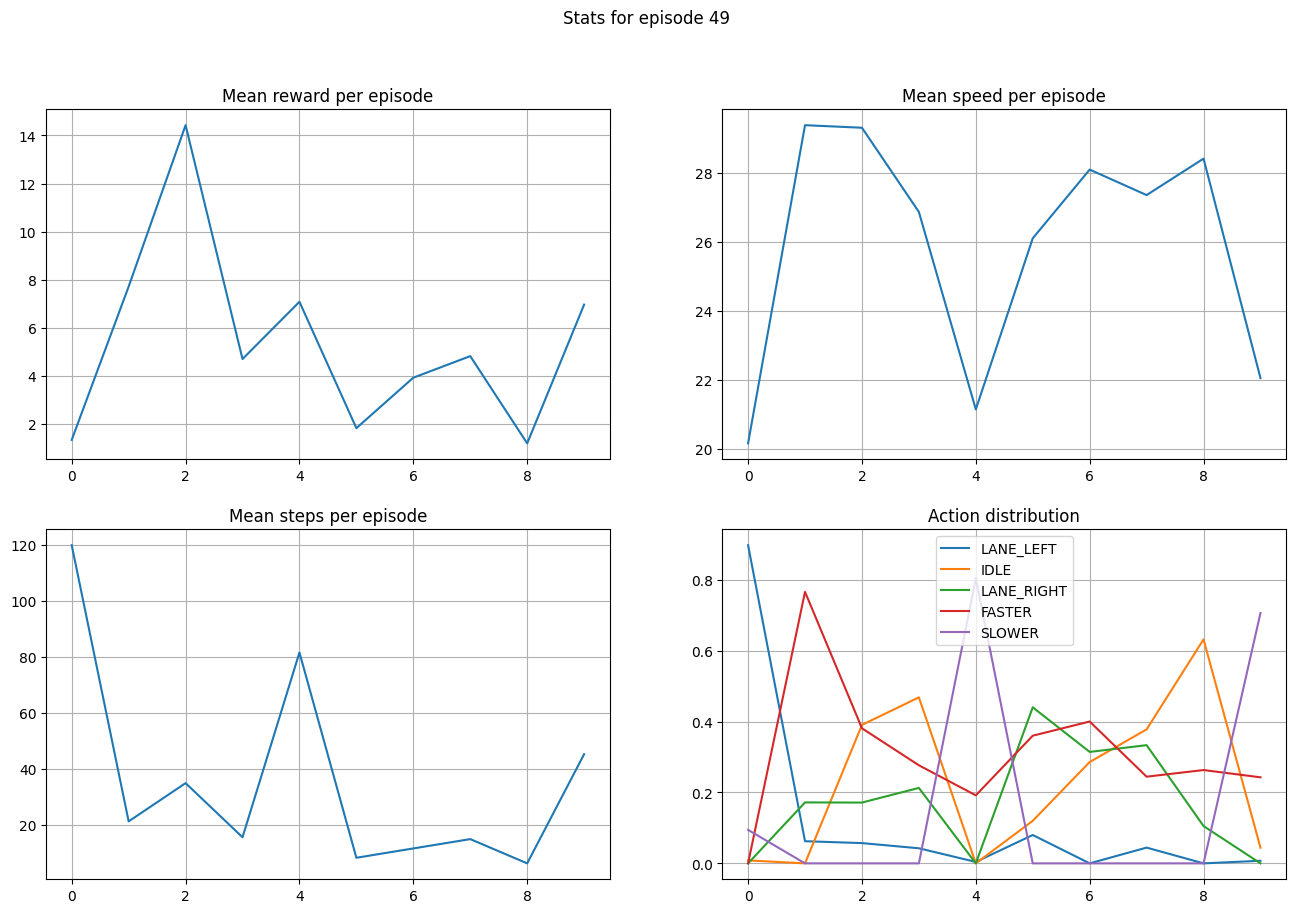

Episode 51 completed on state (0, 0, 1, 0, 0, 1) with cumulative reward: 613.0904159128961, comparable: 313.0205295002761
Episode 52 completed on state (0, 0, 1, 1, 0, 1) with cumulative reward: 172.84630786145982, comparable: 168.93286540837326
Episode 53 completed on state (1, 0, 1, 0, 1, 0) with cumulative reward: 1357.1094462945596, comparable: 386.0622412735278


In [27]:
sarsa.train(m=200, max_steps=200, verbose=1, render=False, show_progress=5)

In [57]:
sarsa.evaluate(iterations=10, render=False)

  0%|          | 0/10 [00:00<?, ?it/s]

(8.490851197919365, 103.8, 0.08180010787976268, 20.779430387360712)

In [46]:
# TODO learn the best danger thresholds !!

Q = Q_learning(print_stats=True, 
        epsilon=1,
        epsilon_decay=0.98,
        min_epsilon=0.1,
        alpha=0.05,
        gamma=0.85,
        state_type='danger', 
        policy_frequency=2,    
        sim_frequency=20,      
        danger_threshold_x=15, 
        danger_threshold_y=10,
        x_speed_coef=1.25,
        y_speed_coef=0.5,
        lane_tolerance=2,
        collision_reward=-100,
        high_speed_reward=10,
        reward_speed_range=[20, 30],
        to_right_reward=15,  # 15
        to_right_skewness=8,         # 2 Skew more ? Increase to_right_reward and skew? 
        change_lane_reward=-1,     # -0.25 Changing lanes too often (0,0,0,0,1) best action is lane left. Maybe skew more ? 
        special_Q=True, 
        past_action_len=3)  

Number of states: 160


In [ ]:
Q.train(m=200, max_steps=200, verbose=2, show_progress=50, render=True)

In [ ]:
import random 

parameter_ranges = {
    'alphas': np.arange(0.05, 0.2, 0.025),  
    'eps_decays': np.arange(0.95, 0.99, 0.005), 
    'sim_frequencies': [20], 
    'policy_frequencies': [1, 2, 3, 4],
    'gammas': np.arange(0.8, 1.0, 0.025),
    'x_speed_coefs': np.arange(0.9, 1.5, 0.05), 
    'y_speed_coefs': np.arange(0.5, 0.9, 0.1),
    'danger_threshold_xs' : np.arange(10, 20, 2),
    'danger_threshold_ys': np.arange(10, 20, 2),
    'past_action_len' : np.arange(2, 4, 1)
}

for i in range(20): 
    selected_parameters = {key: random.choice(value) for key, value in parameter_ranges.items()}
    print(selected_parameters)

    Q = Q_learning(
        print_stats=True, 
        epsilon=1,
        epsilon_decay=selected_parameters['eps_decays'],
        min_epsilon=0.1,
        alpha=selected_parameters['alphas'],
        gamma=selected_parameters['gammas'],
        state_type='danger', 
        policy_frequency=selected_parameters['policy_frequencies'],    
        sim_frequency=selected_parameters['sim_frequencies'],   
        danger_threshold_x=selected_parameters['danger_threshold_xs'],
        danger_threshold_y=selected_parameters['danger_threshold_ys'],
        x_speed_coef=selected_parameters['x_speed_coefs'],
        y_speed_coef=selected_parameters['y_speed_coefs'],
        lane_tolerance=2,
        collision_reward=-100,
        high_speed_reward=10,
        reward_speed_range=[20, 30],
        to_right_reward=15,
        to_right_skewness=8,
        change_lane_reward=-1,
        special_Q=True, 
        past_action_len=int(selected_parameters['past_action_len'])
)  

    Q.train(m=200, max_steps=150, verbose=0, show_progress=300, render=False)

    print(np.mean(Q.rewards_hist_compare[-40:]))

    Q.save()

In [ ]:
Q = Q_learning.load(f'saved_models/{model}')

In [36]:
# Go to the domain saved_models and load the models 
models = ['model_Q_learning_20240611-1522.pkl',
          'model_Q_learning_20240611-2133.pkl', 
          'model_Q_learning_20240611-2248.pkl', 
          'model_Q_learning_20240611-2346.pkl', 
          'model_Q_learning_20240612-0056.pkl',
          'model_Q_learning_20240612-0149.pkl',
          'model_Q_learning_20240612-0430.pkl',
          'model_Q_learning_20240612-1229.pkl', 
          'model_Q_learning_20240612-1434.pkl', 
          'model_Q_learning_20240612-1606.pkl', 
          'model_Q_learning_20240612-1721.pkl'
          ]

evaluations = {}
for model in models:
    model_Q = Q_learning.load(f'saved_models/{model}')
    Q_dict = model_Q.Q.copy()
    Q = Algorithm(Q=Q_dict, special_Q=True)
    mean_reward, mean_step, mean_reward_per_step, mean_speed = Q.evaluate(iterations=10, render=False)
    model_name = model.split('_')[-1].split('.')[0]
    evaluations[model_name] = (mean_reward, mean_step, mean_reward_per_step, mean_speed)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [39]:
for key, value in evaluations.items():
    mean_reward, mean_step, mean_reward_per_step, mean_speed = value
    print(f'{key}: Mean reward: {mean_reward}, Mean steps: {mean_step}, Mean reward per step: {mean_reward_per_step}, Mean speed: {mean_speed}')

20240611-1522: Mean reward: 30.846282146980762, Mean steps: 80.8, Mean reward per step: 0.381760917660653, Mean speed: 27.52351006686382
20240611-2133: Mean reward: 16.327028576603983, Mean steps: 83.5, Mean reward per step: 0.19553327636651477, Mean speed: 25.140406864089343
20240611-2248: Mean reward: 20.90660186277959, Mean steps: 56.2, Mean reward per step: 0.37200359186440546, Mean speed: 28.285260924072748
20240611-2346: Mean reward: 2.8760539541343397, Mean steps: 18.7, Mean reward per step: 0.15379967669167594, Mean speed: 26.313013481851165
20240612-0056: Mean reward: 20.71356027565728, Mean steps: 52.6, Mean reward per step: 0.3937939215904426, Mean speed: 29.322889797025095
20240612-0149: Mean reward: 10.61289778262812, Mean steps: 59.0, Mean reward per step: 0.17987962343437494, Mean speed: 24.691969405405704
20240612-0430: Mean reward: 9.141073288554344, Mean steps: 87.0, Mean reward per step: 0.10506980791441774, Mean speed: 21.321007552869393
20240612-1229: Mean reward: 

In [41]:
a = 'model_Q_learning_20240611-1522.pkl'
model_Q = Q_learning.load(f'saved_models/model_Q_learning_20240611-1522.pkl')


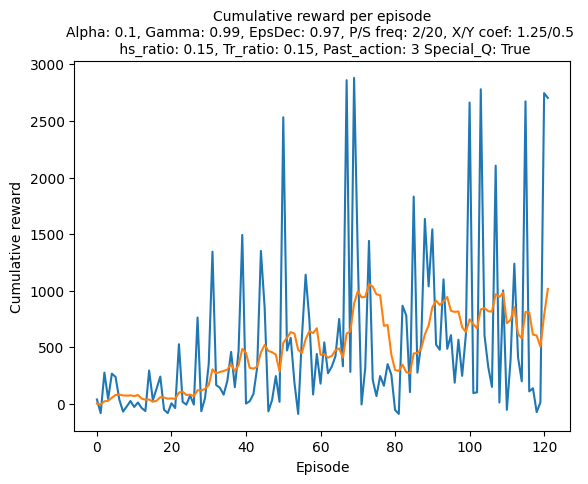

In [45]:
model_Q.plot_rewards_history(relative=False)

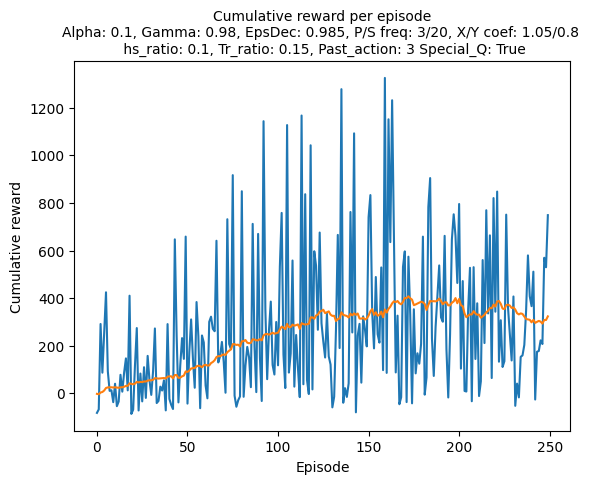

In [44]:
Q.plot_rewards_history(relative=False, smoothing=40, compare=True)

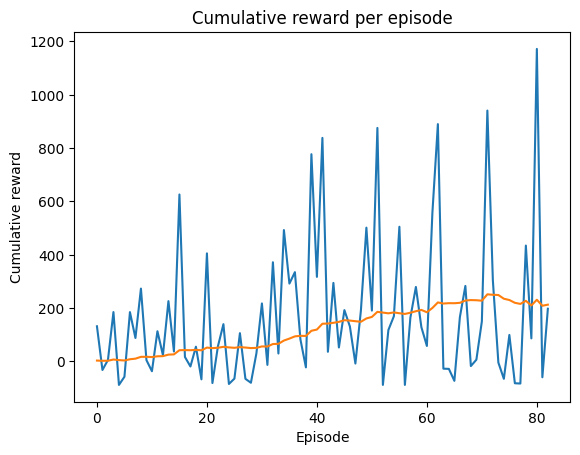

In [20]:
Q.plot_rewards_history(relative=False, smoothing=40)

In [43]:
Q.test(sleep_time=0, time_after_crash=1, max_steps=200)

(1, 0, 0, 0, 1, 1) LANE_LEFT 21.74275997056268
(0, 0, 0, 1, 0, 1) FASTER 25.29132625074019
(0, 0, 1, 1, 0, 1) LANE_LEFT 21.873295661118085
(0, 0, 1, 1, 0, 1) LANE_LEFT 18.480816396844048
(1, 0, 0, 1, 0, 1) LANE_LEFT 15.917890231449853
(0, 0, 0, 1, 0, 1) FASTER 17.04486222438905
(0, 0, 0, 1, 0, 1) FASTER 16.988458451019035
(0, 0, 0, 1, 0, 1) FASTER 16.96162697254654
(0, 0, 0, 0, 0, 0) LANE_LEFT 14.822533118337677
(1, 0, 1, 0, 0, 1) LANE_LEFT 13.686086540143522
(1, 0, 1, 0, 0, 1) LANE_LEFT 13.142434662245627
(0, 0, 1, 1, 0, 1) LANE_LEFT -100.910987926592


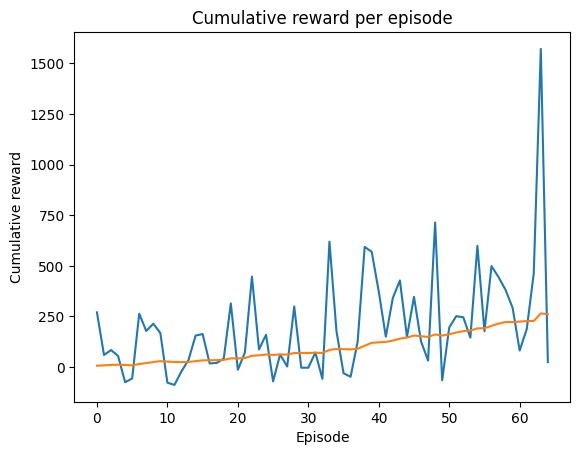

In [13]:
Q.plot_rewards_history(relative=False, smoothing=40)

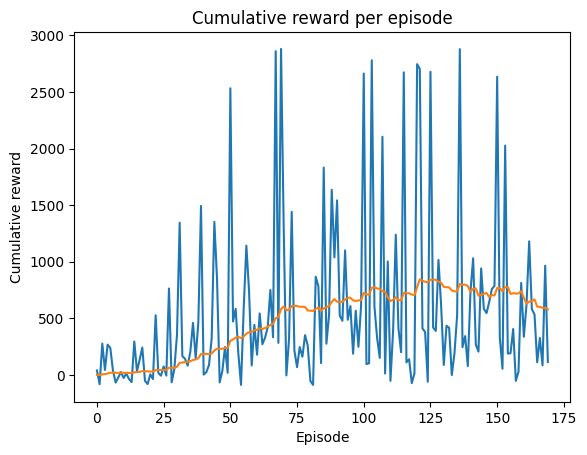

In [106]:
Q.plot_rewards_history(relative=False, smoothing=40)

In [101]:
Q.save()

In [118]:
a = Algorithm.load('saved_models/model_Q_learning_20240611-1522.pkl')

In [132]:
# Print all the parameters of the model a 
for key, value in a.__dict__.items():
    print(key, value)

config {'lanes_count': 10, 'vehicles_count': 50, 'duration': 50, 'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle', 'initial_spacing': 2, 'observation': {'type': 'Kinematics', 'vehicles_count': 50, 'features': ['x', 'y', 'vx', 'vy'], 'absolute': False, 'normalize': False}, 'action': {'type': 'DiscreteMetaAction'}, 'simulation_frequency': 20, 'policy_frequency': 2, 'collision_reward': -100, 'right_lane_reward': 0.1, 'high_speed_reward': 15, 'lane_change_reward': 0, 'reward_speed_range': [20, 30], 'screen_width': 800, 'screen_height': 600, 'centering_position': [0.5, 0.5], 'scaling': 5, 'show_trajectories': True, 'render_agent': True, 'offscreen_rendering': False, 'normalize_reward': False}
seed None
render_mode human
to_right_reward 15
to_right_skewness 6
change_lane_reward -1
policy None
env <OrderEnforcing<PassiveEnvChecker<HighwayEnv<highway-v0>>>>
current_obs [[ 2.3867922e+03  4.0000000e+00  3.0000000e+01  1.7370793e-22]
 [ 9.2807573e-01  2.4000000e+01 -6.2240019e+00 

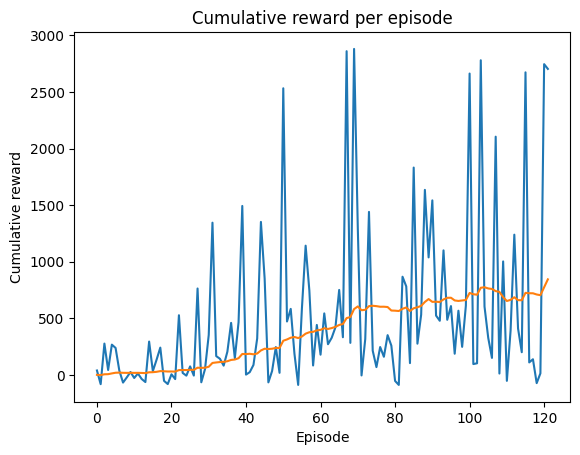

In [127]:
a.plot_rewards_history(relative=False, smoothing=40)

In [25]:
Q.test(sleep_time=0, time_after_crash=1, max_steps=200)

(0, 0, 0, 0, -1, 0) FASTER 11.858220840865554
(0, 0, 0, 0, -1, 0) FASTER 13.68389649536379
(0, 0, 0, 0, -1, 0) FASTER 14.448679125049356
(0, 0, 0, 0, -1, 0) FASTER 14.769049542011246
(0, 0, 0, 0, -1, 0) FASTER 14.903253955239785
(0, 0, 0, 1, -1, 0) FASTER 14.959472705712496
(0, 0, 0, 1, -1, 0) FASTER 14.98302295885752
(1, 0, 0, 1, -1, 0) LANE_RIGHT 13.572701102596152
(0, 0, 0, 1, -1, 1) LANE_LEFT 13.849652668960921
(1, 0, 0, 1, -1, 1) LANE_RIGHT 13.792818206686368
(0, 0, 1, 0, 0, 1) IDLE 14.965995531445301
(0, 0, 1, 0, 0, 1) IDLE 15.006563971900977
(0, 0, 1, 0, 0, 1) IDLE 15.010746166262914
(0, 0, 1, 0, 0, 0) IDLE 15.011092062360728
(1, 0, 0, 0, 0, 0) LANE_RIGHT 13.590230061706704
(0, 0, 0, 0, 0, 1) LANE_RIGHT 13.17146416439044
(0, 0, 0, 0, 0, 1) LANE_RIGHT 13.064321895998258
(0, 0, 1, 1, 0, 1) IDLE 15.016329485860917
(1, 0, 0, 1, 0, 1) LANE_LEFT 13.794253579865279
(0, 0, 1, 1, 0, 0) FASTER 15.009517184748628
(0, 0, 1, 1, 0, 1) IDLE 15.057123789977007
(0, 0, 0, 1, 0, 1) FASTER 15.06087

KeyboardInterrupt: 

In [32]:
Q.search_Q((1, 0, 0, 0, 1, 0))

{'IDLE': 59.83451281349414,
 'LANE_RIGHT': 26.148314796652325,
 'FASTER': 15.687810841564858,
 'LANE_LEFT': 3.5485162909544004,
 'SLOWER': 1.6222061742120388}

In [196]:
optimum_q_kinematics

{(0, 0, 0, 0, 0): 3,
 (0, 0, 0, 0, 1): 3,
 (0, 0, 0, 0, -1): 2,
 (1, 0, 0, 0, 0): 2,
 (1, 0, 0, 0, 1): 0,
 (1, 0, 0, 0, -1): 2,
 (0, 0, 1, 0, 0): 2,
 (0, 0, 1, 0, 1): 3,
 (0, 0, 0, 1, 0): 3,
 (0, 0, 0, 1, -1): 3,
 (1, 0, 1, 1, 0): 4,
 (0, 0, 1, 1, 0): 3,
 (1, 0, 0, 1, 0): 0,
 (1, 0, 0, 1, -1): 4,
 (1, 0, 1, 0, 0): 2,
 (1, 0, 1, 0, 1): 4}

In [22]:
q_actions = {state: np.argmax([Q.Q[(state, action)] for action in range(5)]) for state in Q.states}
for state in optimum_q_kinematics.keys():
    print(state, f' -> mine: {decode_meta_action(q_actions[state])} { round(Q.search_Q(state)[decode_meta_action(q_actions[state])],2) }, '
          , f'optimum: {decode_meta_action(optimum_q_kinematics[state])} { round(Q.search_Q(state)[decode_meta_action(optimum_q_kinematics[state])],2) }')

(0, 0, 0, 0, 0, 0)  -> mine: FASTER 142.95,  optimum: LANE_RIGHT 46.48
(0, 0, 0, 0, 1, 0)  -> mine: FASTER 227.31,  optimum: FASTER 227.31
(0, 0, 0, 0, -1, 0)  -> mine: FASTER 16.07,  optimum: LANE_RIGHT 4.16
(1, 0, 0, 0, 0, 0)  -> mine: LANE_RIGHT 34.47,  optimum: LANE_RIGHT 34.47
(1, 0, 0, 0, 1, 0)  -> mine: IDLE 59.83,  optimum: LANE_LEFT 3.55
(1, 0, 0, 0, -1, 0)  -> mine: LANE_RIGHT 0.29,  optimum: LANE_RIGHT 0.29
(0, 0, 1, 0, 0, 0)  -> mine: IDLE 109.1,  optimum: LANE_RIGHT 43.91
(0, 0, 1, 0, 1, 0)  -> mine: LANE_RIGHT 280.63,  optimum: FASTER 60.04
(0, 0, 0, 1, 0, 0)  -> mine: IDLE 71.44,  optimum: FASTER 30.54
(0, 0, 0, 1, -1, 0)  -> mine: FASTER 4.15,  optimum: FASTER 4.15
(1, 0, 1, 1, 0, 0)  -> mine: IDLE 12.12,  optimum: SLOWER 0
(0, 0, 1, 1, 0, 0)  -> mine: FASTER 71.71,  optimum: FASTER 71.71
(1, 0, 0, 1, 0, 0)  -> mine: LANE_RIGHT 21.37,  optimum: LANE_LEFT 1.35
(1, 0, 0, 1, -1, 0)  -> mine: LANE_RIGHT 2.75,  optimum: SLOWER 0
(1, 0, 1, 0, 0, 0)  -> mine: LANE_RIGHT 28.16,

In [102]:
Q.search_Q((0, 0, 0, 0, -1, 0))

{'IDLE': 39.23231392942805,
 'FASTER': 25.106315564406323,
 'LANE_RIGHT': 24.587116718189687,
 'SLOWER': 19.83407492435054,
 'LANE_LEFT': 16.890837515325952}

In [34]:
Q.test(sleep_time=0, time_after_crash=0)

(0, 0, 0, 1, 0, 0) IDLE 9.322496570644718
(0, 0, 0, 1, 0, 0) IDLE 9.322496570644718
(0, 0, 0, 1, 0, 0) IDLE 9.322496570644718
(0, 0, 0, 1, 0, 0) IDLE 9.322496570644718
(0, 0, 0, 1, 0, 0) IDLE 9.322496570644718
(0, 0, 0, 1, 0, 0) IDLE 9.322496570644718
(0, 0, 0, 1, 0, 0) IDLE 9.322496570644718
(0, 0, 0, 1, 0, 0) IDLE 9.322496570644718
(0, 0, 0, 0, 0, 0) FASTER 13.680717411510273
(0, 0, 0, 0, 0, 0) FASTER 15.506393066008508
(0, 0, 0, 0, 0, 0) FASTER 16.271175695694073
(0, 0, 0, 0, 0, 0) FASTER 16.591546112655962
(0, 0, 1, 0, 0, 0) IDLE 16.725750525884504
(0, 0, 1, 0, 0, 0) IDLE 16.781969276357213
(0, 0, 1, 0, 0, 0) IDLE 16.805519529502238
(0, 0, 1, 0, 0, 0) IDLE 16.815384822105354
(0, 0, 0, 0, 0, 0) FASTER 16.819517431531924
(0, 0, 0, 0, 0, 0) FASTER 16.821248597687816
(0, 0, 0, 0, 0, 0) FASTER 16.8219737899211
(0, 0, 1, 0, 0, 0) IDLE 16.82227757576708
(0, 0, 1, 0, 0, 0) IDLE 16.822404832839045
(0, 0, 1, 0, 0, 0) IDLE 16.82245814132125
(0, 0, 1, 0, 0, 0) IDLE 16.82248047245171
(0, 0, 1, 

#### Testing the optimum Q kinematics

In [ ]:
Q = Q_learning(print_stats=True, 
        epsilon=1, 
        epsilon_decay=0.96,
        min_epsilon=0.1,
        alpha=0.1, 
        gamma=0.98, 
        state_type='danger', 
        policy_frequency=2,    # 2
        sim_frequency=20,     # 10 
        danger_threshold_x=15,  #15
        danger_threshold_y=13,  #15 
        x_speed_coef=1, #1.5
        y_speed_coef=0.5, #1.5
        colision_reward=-100,
        high_speed_reward=5,
        reward_speed_range=[20, 30],
        to_right_reward=5, 
        to_right_skewness=20,
        change_lane_reward=-2.5, 
        lane_tolerance=2, 
        special_Q=True)   

Q.Q = {}
for key, value in optimum_q_kinematics.items():
    for i in range(6): 
        if i == value:
            Q.Q[key, i] = 1
        else:
            Q.Q[key, i] = 0

Q.test(sleep_time=0.1, time_after_crash=5)